In [7]:
import os
import numpy as np
import pandas as pd
from scipy import integrate
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')

In [2]:
ncfs = [10, 20, 30]
knn_nbrs = [0, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100]
simdir_fmt = '12639_450_{:d}_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02'
srcdir = '/cbscratch/sbanerj/trans-eqtl/simulation'

In [45]:
# fprcut = 0.1
# data_csv_file = 'simulation_knn_auc01_comparison.txt'
# ymax = 0.1
# yshift = 0.0
# ymajorticks = [0.0, 0.05, 0.1]

fprcut = 1.0
data_csv_file = 'simulation_knn_auc_comparison.txt'
ymax = 1.0
yshift = 0.5
ymajorticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [46]:
data  = dict()
errup = dict()
errdn = dict()
for ncf in ncfs:
    data[ncf]  = dict()
    errup[ncf] = dict()
    errdn[ncf] = dict()
    for knn_nbr in knn_nbrs:
        data[ncf][knn_nbr]  = dict()
        errup[ncf][knn_nbr] = dict()
        errdn[ncf][knn_nbr] = dict()
        rocfile = os.path.join(srcdir, simdir_fmt.format(ncf), 
                               'rocdata/tejaas_permnull_sb0.1_raw_knn{:d}_peer0_fpr_tpr.txt'.format(knn_nbr))
        success = False
        if os.path.exists(rocfile):
            roc = np.loadtxt(rocfile, skiprows=1)
            xx = roc[:, 0]
            yy = roc[:, 1]
            ystd = roc[:, 2]
            idx = np.where(xx <= fprcut)[0]
            if idx.shape[0] > 5:
                auc = integrate.simps(yy[idx], xx[idx])
                aucup = integrate.simps(yy[idx] + ystd[idx], xx[idx])
                aucdn = integrate.simps(yy[idx] - ystd[idx], xx[idx])
                data[ncf][knn_nbr]  = auc
                errup[ncf][knn_nbr] = aucup
                errdn[ncf][knn_nbr] = aucdn
                success = True
        if not success:
            yrand = np.linspace(0, fprcut, 100)
            auc = integrate.simps(yrand, yrand)
            data[ncf][knn_nbr]  = auc
            errup[ncf][knn_nbr] = auc
            errdn[ncf][knn_nbr] = auc

In [47]:
colnames = [f'{x}' for x in ncfs] + [f'{x}_errup' for x in ncfs] + [f'{x}_errdn' for x in ncfs]

datadf = pd.DataFrame(index=knn_nbrs, columns=colnames)
for fn in datadf.index:
    fndata = [data[x][fn] for x in ncfs] + \
             [errup[x][fn] for x in ncfs] + \
             [errdn[x][fn] for x in ncfs]
    datadf.loc[fn] = fndata
    
datadf.to_csv(data_csv_file)
datadf

,10,20,30,10_errup,20_errup,30_errup,10_errdn,20_errdn,30_errdn
0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
5,0.95675,0.920815,0.887242,0.978145,0.953774,0.920407,0.935355,0.887857,0.854077
10,0.976132,0.944886,0.915836,0.989511,0.972919,0.94404,0.962752,0.916853,0.887633
15,0.978822,0.949818,0.922468,0.991561,0.976289,0.949351,0.966083,0.923347,0.895585
20,0.979375,0.950885,0.924022,0.992091,0.97747,0.950237,0.966659,0.9243,0.897806
30,0.978443,0.950682,0.924645,0.992501,0.976281,0.951106,0.964384,0.925083,0.898183
40,0.977659,0.949031,0.923369,0.992236,0.974512,0.950398,0.963083,0.92355,0.89634
50,0.976317,0.947648,0.922134,0.991714,0.973694,0.949173,0.960921,0.921602,0.895095
60,0.974709,0.94616,0.920265,0.990593,0.972745,0.947436,0.958824,0.919576,0.893094
80,0.968744,0.939425,0.916351,0.987117,0.968084,0.944588,0.95037,0.910766,0.888113


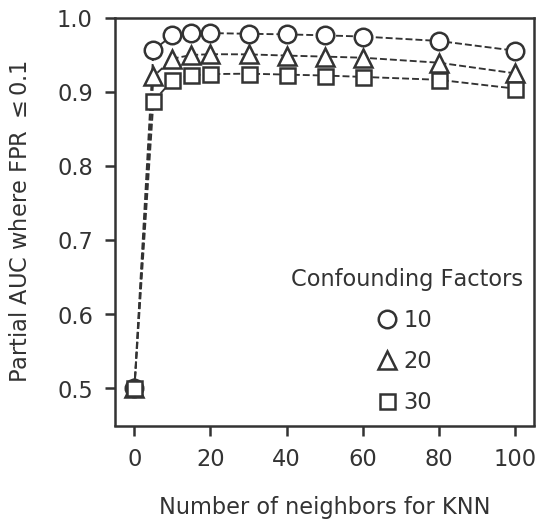

In [48]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

ncfmarkers = {10: 'o', 20: '^', 30: 's'}
ncfmarkersizes = {10: 14, 20: 15, 30: 12}
ncflabels = {10: '10', 20: '20', 30: '30'}
ncfcolors = {10: '#ffffff', 20: '#ffffff', 30: '#ffffff'}
showerror = False


for ncf in ncfs:
    ncfstr = f'{ncf}'
    yvals = datadf.loc[knn_nbrs, ncfstr].tolist()
    ax1.plot(knn_nbrs, yvals,
             marker = ncfmarkers[ncf],
             markersize = ncfmarkersizes[ncf], 
             markerfacecolor = ncfcolors[ncf],
             markeredgewidth = 2,
             markeredgecolor = '#333333',
             linestyle = None, linewidth = 0,
             label = ncflabels[ncf], zorder = 20)
    ax1.plot(knn_nbrs, yvals, 
             linestyle = 'dashed', color = '#333333', zorder = 10)
    if showerror:
        for i, x in enumerate(knn_nbrs):
            errmin = datadf.at[x, f'{ncfstr}_errdn']
            errmax = datadf.at[x, f'{ncfstr}_errup']
            ax1.plot([x, x], [errmin, errmax], color = '#333333', zorder = 10)

ax1.set_xlabel('Number of neighbors for KNN')
ax1.set_ylabel('Partial AUC where FPR $\leq 0.1$')
ax1.legend(loc = 'lower right', title = 'Confounding Factors')

ax1.set_ylim(yshift - (ymax/20), ymax)
#plt.savefig('../plots/npeer_tejaas_rr_diff_ntrans_mean04_gtex_ms_correlation.png', bbox_inches='tight')
plt.show()